<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week11/AE_WISDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA # PCA 임포트
import re # WISDM 데이터 정리를 위해 추가

# PyTorch 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [17]:
# 1. WISDM 데이터 로드 및 전처리
# WISDM v1.1 raw 데이터셋을 불러옵니다.
# 출처: https://www.cis.fordham.edu/wisdm/dataset.php
# (공개된 raw 링크 사용)
data_url = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt'
column_names = ['user', 'activity', 'timestamp', 'x', 'y', 'z']

try:
    # 데이터 로드 시 ; 로 끝나는 불완전한 라인이나 오류가 있는 라인을 스킵합니다.
    df = pd.read_csv(data_url, header=None, names=column_names, on_bad_lines='skip')
except Exception as e:
    print(f"오류: 데이터 로드 실패 - {e}")
    print("데이터셋 URL을 확인하거나 로컬 파일을 사용해주세요.")
    df = pd.DataFrame()

# %%
if not df.empty:
    print("--- 원본 데이터 (처음 5줄) ---")
    print(df.head())
    print(f"\n원본 데이터 shape: {df.shape}")

--- 원본 데이터 (처음 5줄) ---
   user activity       timestamp         x          y             z
0    33  Jogging  49105962326000 -0.694638  12.680544   0.50395286;
1    33  Jogging  49106062271000  5.012288  11.264028   0.95342433;
2    33  Jogging  49106112167000  4.903325  10.882658  -0.08172209;
3    33  Jogging  49106222305000 -0.612916  18.496431    3.0237172;
4    33  Jogging  49106332290000 -1.184970  12.108489     7.205164;

원본 데이터 shape: (1086466, 6)


In [18]:
# 2. 결측치 및 데이터 타입 확인
if not df.empty:
    print("\n--- 데이터 클리닝 전 ---")
    # print(df.info()) # .info()는 .py 파일에서 상세히 보이지 않으므로 일부 정보만 출력
    print(f"Entries: {len(df)}")

    # z축 데이터에 세미콜론(;)이 붙어있는 경우가 있어 제거합니다.
    df['z'] = df['z'].astype(str).str.replace(';', '', regex=False)

    # x, y, z를 숫자형으로 변환 (변환할 수 없는 값은 NaT/NaN으로)
    df['x'] = pd.to_numeric(df['x'], errors='coerce')
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df['z'] = pd.to_numeric(df['z'], errors='coerce')

    # 변환 과정에서 생긴 NaN 값을 포함한 행을 제거합니다.
    df.dropna(inplace=True)

    print("\n--- 데이터 클리닝 후 ---")
    print(f"클리닝 후 데이터 shape: {df.shape}")
    print(f"사용 가능한 Activity: {df['activity'].unique()}")



--- 데이터 클리닝 전 ---
Entries: 1086466

--- 데이터 클리닝 후 ---
클리닝 후 데이터 shape: (1086465, 6)
사용 가능한 Activity: ['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']



--- Activity 분포 PCA 시각화 (샘플 50,000개) ---


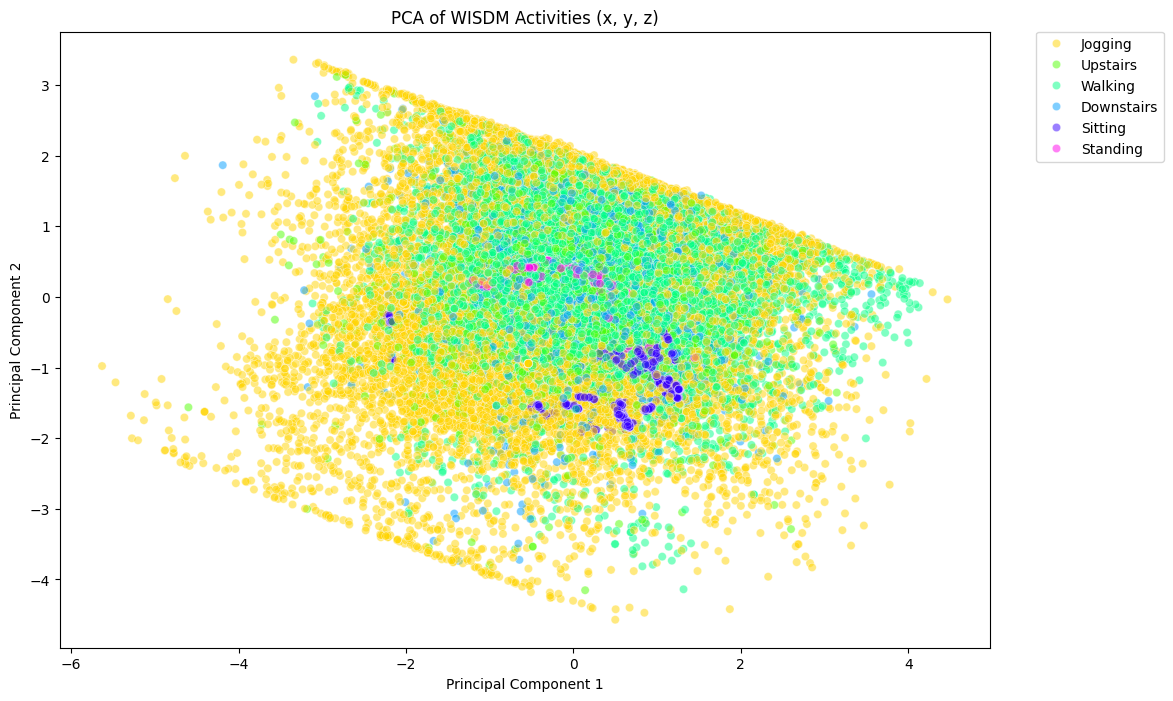

PCA 플롯을 보고 서로 멀리 떨어진 Activity 2개를 선택하세요.
예: 'Walking'(정상)과 'Sitting'(비정상)이 'Jogging'/'Sitting'보다 나을 수 있습니다.
이 스크립트는 'Walking'을 정상, 'Sitting'을 비정상으로 사용합니다.



In [19]:
# 3. (NEW) Activity 분포 시각화 (PCA)
# 어떤 Activity를 Normal/Abnormal로 고를지 결정하기 위한 시각화
if not df.empty:
    print("\n--- Activity 분포 PCA 시각화 (샘플 50,000개) ---")

    # 데이터가 너무 많으므로 5만개 샘플링
    if len(df) > 50000:
        df_sample = df.sample(50000, random_state=42).copy()
    else:
        df_sample = df.copy()

    scaler_pca = StandardScaler()
    features = ['x', 'y', 'z']
    df_sample[features] = scaler_pca.fit_transform(df_sample[features])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_sample[features])

    df_sample['pca1'] = pca_result[:, 0]
    df_sample['pca2'] = pca_result[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue="activity",
        palette=sns.color_palette("hsv", len(df_sample['activity'].unique())),
        data=df_sample,
        legend="full",
        alpha=0.5
    )
    plt.title('PCA of WISDM Activities (x, y, z)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    print("PCA 플롯을 보고 서로 멀리 떨어진 Activity 2개를 선택하세요.")
    print("예: 'Walking'(정상)과 'Sitting'(비정상)이 'Jogging'/'Sitting'보다 나을 수 있습니다.")
    print("이 스크립트는 'Walking'을 정상, 'Sitting'을 비정상으로 사용합니다.\n")


In [20]:
# 4. 'Walking' (정상)과 'Sitting' (비정상) 데이터만 필터링
if not df.empty:
    NORMAL_ACTIVITY = 'Standing'
    ABNORMAL_ACTIVITY = 'Sitting'

    df = df[(df['activity'] == NORMAL_ACTIVITY) | (df['activity'] == ABNORMAL_ACTIVITY)].copy()
    print(f"\n{NORMAL_ACTIVITY}/{ABNORMAL_ACTIVITY} 필터링 후 shape: {df.shape}")



Standing/Sitting 필터링 후 shape: (108333, 6)



--- 선택된 Activity 별 데이터 개수 ---
activity
Sitting     59939
Standing    48394
Name: count, dtype: int64


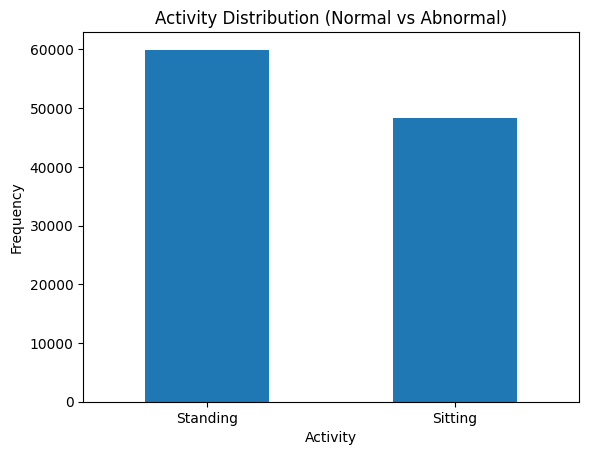

In [21]:
# 5. 데이터 탐색 (선택된 Activity)
LABELS = [NORMAL_ACTIVITY, ABNORMAL_ACTIVITY]

if not df.empty:
    # 데이터의 개수 찍어보기
    count_classes = df['activity'].value_counts()
    print("\n--- 선택된 Activity 별 데이터 개수 ---")
    print(count_classes)

    count_classes.plot(kind = 'bar', rot=0)
    plt.title("Activity Distribution (Normal vs Abnormal)")
    plt.xticks(range(2), LABELS)
    plt.xlabel("Activity")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("데이터프레임이 비어있어 플롯을 생성할 수 없습니다.")


In [22]:
# 6. 피처 엔지니어링 및 정규화
if not df.empty:
    # Activity 인코딩
    # 'Walking' (정상) -> 0, 'Sitting' (비정상) -> 1
    df['activity_encoded'] = df['activity'].apply(lambda x: 0 if x == NORMAL_ACTIVITY else 1)

    # 사용할 피처(x, y, z)와 타겟(activity_encoded)만 선택
    data = df[['x', 'y', 'z', 'activity_encoded']].copy()

    # 피처 스케일링 (x, y, z)
    scaler = StandardScaler()
    data[['x', 'y', 'z']] = scaler.fit_transform(data[['x', 'y', 'z']])

    print("\n--- 스케일링 및 인코딩 후 데이터 ---")
    print(data.head())
else:
    print("데이터프레임이 비어있어 피처 엔지니어링을 건너뜁니다.")


--- 스케일링 및 인코딩 후 데이터 ---
               x         y         z  activity_encoded
221331  0.475616  1.055290 -0.683953                 1
221332  0.493740  1.025594 -0.811279                 1
221333  0.677254  0.879401 -0.749249                 1
221334  0.711238  0.991330 -0.710071                 1
221335  0.545849  0.982193 -0.683953                 1


In [24]:
# %%
# 7. 훈련 / 테스트 데이터 분할
RANDOM_SEED = 42

if not df.empty:
    # 1. 전체 데이터를 훈련셋(80%)과 테스트셋(20%)으로 분할
    X_train_df, X_test_df = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=data['activity_encoded'])

    # 2. 훈련셋(X_train_df)은 오직 정상('Walking', 0) 데이터만 사용
    X_train_df = X_train_df[X_train_df['activity_encoded'] == 0]
    X_train_df = X_train_df.drop(['activity_encoded'], axis=1) # 레이블 제거

    # 3. 테스트셋(X_test_df)은 정상('Walking')과 비정상('Sitting') 데이터를 모두 포함
    y_test_series = X_test_df['activity_encoded'] # 테스트용 레이블
    X_test_df = X_test_df.drop(['activity_encoded'], axis=1) # 테스트용 피처

    print(f"\n--- 데이터 분할 결과 ---")
    print(f"X_train_df (정상 데이터만) shape: {X_train_df.shape}")
    print(f"X_test_df (정상+비정상) shape: {X_test_df.shape}")
    print(f"y_test_series (테스트 레이블) shape: {y_test_series.shape}")
    print(f"Test set '{ABNORMAL_ACTIVITY}' (1) count: {y_test_series.value_counts()[1]}")


    # 8. PyTorch용 Tensor 변환 및 DataLoader 생성

    # Keras의 validation_split=0.1을 재현하기 위해 train_data를 다시 분할
    X_train_tensor = torch.tensor(X_train_df.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_series.values, dtype=torch.float32)

    # 훈련 데이터(X_train_tensor)를 다시 훈련셋과 검증셋으로 분할 (9:1)
    train_data, val_data = train_test_split(X_train_tensor, test_size=0.1, random_state=RANDOM_SEED)

    print(f"\nTrain data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")

    # DataLoader 생성
    batch_size = 64
    train_dataset = TensorDataset(train_data, train_data) # 입력=타겟
    val_dataset = TensorDataset(val_data, val_data)     # 입력=타겟
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # 피처, 레이블

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # GPU 사용 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
else:
    print("데이터프레임이 비어있어 텐서 변환을 건너뜁니다.")
    # 이후 셀에서 오류가 나지 않도록 빈 변수/객체 생성
    df = pd.DataFrame()
    X_train_df = pd.DataFrame()
    y_test_series = pd.Series()
    device = torch.device("cpu")

# %%
# 테스트 레이블을 남겨두는 이유는 나중에 정확도를 비교하기 위해서임


--- 데이터 분할 결과 ---
X_train_df (정상 데이터만) shape: (38715, 3)
X_test_df (정상+비정상) shape: (21667, 3)
y_test_series (테스트 레이블) shape: (21667,)
Test set 'Sitting' (1) count: 11988

Train data shape: torch.Size([34843, 3])
Validation data shape: torch.Size([3872, 3])
Using device: cuda


In [25]:
# 9. 오토인코더 모델 (PyTorch) - 모델 구조 변경 (Deeper)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()

        # 모델을 더 깊게 만듭니다 (3 -> 16 -> 8 -> 4)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim), # 잠재 공간
            nn.ReLU()
        )

        # 디코더도 대칭적으로 깊게 만듭니다 (4 -> 8 -> 16 -> 3)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            # StandardScaler로 전처리했으므로 Sigmoid를 사용하지 않습니다.
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

if not df.empty:
    # 모델 인스턴스화
    input_dim = X_train_df.shape[1] # 3
    latent_dim = 4 # 잠재 공간 크기

    model = Autoencoder(input_dim, latent_dim).to(device)

    # 손실 함수 및 옵티마이저
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("--- 모델 구조 ---")
    print(model)
else:
    print("데이터가 없어 모델을 초기화하지 않습니다.")

--- 모델 구조 ---
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [26]:
# 10. 모델 학습 (PyTorch)
num_epochs = 50
history = {'train_loss': [], 'val_loss': []}

if not df.empty:
    print("\n--- 모델 학습 시작 ---")
    for epoch in range(num_epochs):
        # --- 훈련 단계 ---
        model.train() # 모델을 훈련 모드로 설정
        running_train_loss = 0.0
        for inputs, _ in train_loader: # 오토인코더이므로 레이블은 무시
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs) # 입력 자신을 타겟으로 손실 계산
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        # --- 검증 단계 ---
        model.eval() # 모델을 평가 모드로 설정
        running_val_loss = 0.0
        with torch.no_grad(): # 기울기 계산 비활성화
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)

        if (epoch + 1) % 5 == 0: # 5 에포크마다 출력
            print(f"Epoch {epoch+1}/{num_epochs} - loss: {epoch_train_loss:.4f} - val_loss: {epoch_val_loss:.4f}")
else:
    print("데이터가 없어 모델 훈련을 건너뜁니다.")



--- 모델 학습 시작 ---
Epoch 5/50 - loss: 0.0020 - val_loss: 0.0015
Epoch 10/50 - loss: 0.0002 - val_loss: 0.0001
Epoch 15/50 - loss: 0.0001 - val_loss: 0.0000
Epoch 20/50 - loss: 0.0000 - val_loss: 0.0000
Epoch 25/50 - loss: 0.0000 - val_loss: 0.0000
Epoch 30/50 - loss: 0.0000 - val_loss: 0.0000
Epoch 35/50 - loss: 0.0000 - val_loss: 0.0000
Epoch 40/50 - loss: 0.0000 - val_loss: 0.0003
Epoch 45/50 - loss: 0.0000 - val_loss: 0.0000
Epoch 50/50 - loss: 0.0000 - val_loss: 0.0000


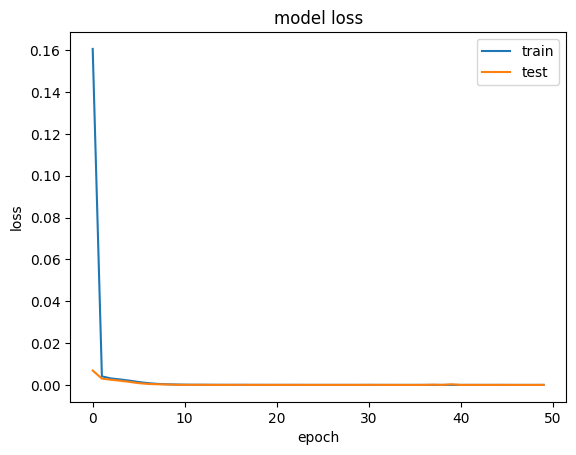

In [27]:
# 11. 학습 곡선 시각화
if not df.empty:
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
else:
    print("훈련 기록이 없어 손실 플롯을 생성할 수 없습니다.")

In [28]:
# 12. 재구성 오류(Reconstruction Error) 계산
if not df.empty:
    model.eval() # 평가 모드
    reconstruction_errors = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            mse = torch.mean(torch.pow(inputs - outputs, 2), dim=1)
            reconstruction_errors.extend(mse.cpu().numpy())

    # 원본 Keras 코드와 동일하게 y_test_series의 인덱스를 사용
    error_df = pd.DataFrame(
        {'reconstruction_error': reconstruction_errors,
         'true_class': y_test_series.values},
        index=y_test_series.index
    )
    print("\n--- 테스트셋 재구성 오류 통계 ---")
    print(error_df.describe())
else:
    print("데이터가 없어 예측 및 오류 계산을 건너뜁니다.")

# %%
if not df.empty:
    print("\n--- 오류 데이터프레임 (상위 5개) ---")
    print(error_df.head())
else:
    print("error_df가 생성되지 않았습니다.")


--- 테스트셋 재구성 오류 통계 ---
       reconstruction_error    true_class
count          2.166700e+04  21667.000000
mean           2.131506e-01      0.553284
std            3.059459e-01      0.497164
min            1.625307e-07      0.000000
25%            4.781764e-06      0.000000
50%            1.276756e-02      1.000000
75%            3.417145e-01      1.000000
max            1.495096e+00      1.000000

--- 오류 데이터프레임 (상위 5개) ---
         reconstruction_error  true_class
1084315              0.111676           1
463364               0.000004           0
434816               0.000004           0
739244               0.763686           1
538276               0.110533           1


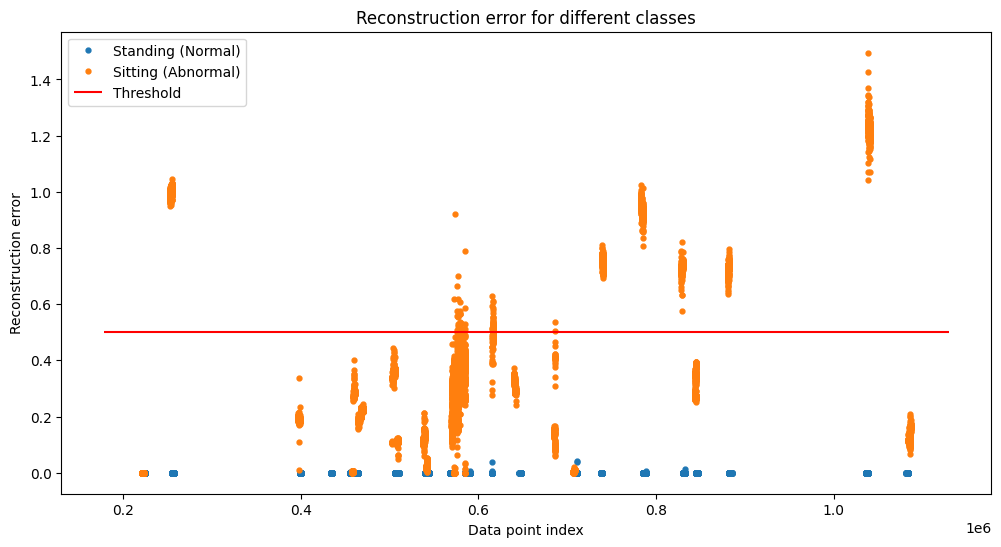

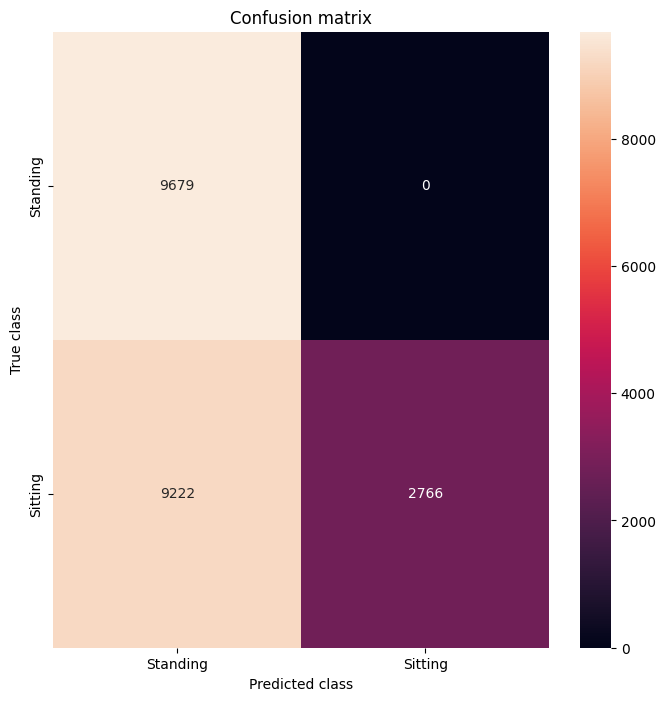


--- 분류 리포트 ---
              precision    recall  f1-score   support

    Standing       0.51      1.00      0.68      9679
     Sitting       1.00      0.23      0.37     11988

    accuracy                           0.57     21667
   macro avg       0.76      0.62      0.53     21667
weighted avg       0.78      0.57      0.51     21667



In [30]:
# 13. 임계값(Threshold) 설정 및 평가
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프로를 보고 결정
# (모델과 데이터가 변경되었으므로 이 값은 조정이 필요합니다. 1.5는 예시입니다.)
# 셀 14의 그래프를 보고 이 값을 조정하세요.
threshold = 0.5

# %%
# 14. 클래스별 재구성 오류 시각화
if not df.empty:
    LABELS_VIZ = [f"{NORMAL_ACTIVITY} (Normal)", f"{ABNORMAL_ACTIVITY} (Abnormal)"]
    groups = error_df.groupby('true_class')
    fig, ax = plt.subplots(figsize=(12, 6))

    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= LABELS_VIZ[int(name)])
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show();
else:
    print("error_df가 생성되지 않아 플롯을 그릴 수 없습니다.")

# %%
# 15. 혼동 행렬(Confusion Matrix) 및 리포트
if not df.empty:
    LABELS_CM = [NORMAL_ACTIVITY, ABNORMAL_ACTIVITY]
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)

    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS_CM, yticklabels=LABELS_CM, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

    print("\n--- 분류 리포트 ---")
    print(classification_report(error_df.true_class, y_pred, target_names=LABELS_CM))
else:
    print("error_df가 생성되지 않아 Confusion Matrix를 생성할 수 없습니다.")